#  Performing geneBasis scheme on Early RPC cells

This Python notebook performs an analysis of the cell types and their marker genes on provided 10X dataset. Specifically, we'll focus on subclustering Early RPC cells. The data set contains ~107,000 cells of which approximately a half come from E14, E18, and P2. 

# 0. Loading the libraries

In [1]:
import scanpy as sc
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import rcParams
from matplotlib import colors
import seaborn as sns
from sklearn.neighbors import NearestNeighbors




In [2]:
sc.settings.verbosity = 3            
sc.settings.set_figure_params(dpi=80, facecolor='white')
plt.rcParams['figure.figsize']=(6,6) #rescale figures

Defining main fuction to compute Minkowski distances between each gene's true expresion ant average expression among each cell's neighbours. "True neighbours" are obtained from whole data(using first 100 principal components), 'predicted neighbours' are obtained based on the expression of the selected gene panel. Difference between minkowski distance obtaine from "True graph" and "predicted graph" determines which gene to add to the panel. 

In [3]:
def gdis_cell_neigh(XM, Xa_pca=[],neigh_graph=[],num_neigh=6, return_distance=False):

    if (len(neigh_graph)>0):
        knn=neigh_graph
        knnt=neigh_graph

    else:
        neigh = NearestNeighbors(n_neighbors=num_neigh).fit(Xa_pca)
        knnt=neigh.kneighbors(Xa_pca, return_distance=return_distance)
        if return_distance:
            knn=knnt[1]
        else:
            knn=knnt
    num_neigh=knn.shape[1]-1


    XMS=XM[knn[:,num_neigh],:]
    for ii in range(1,num_neigh):
        XMS=XMS+XM[knn[:,ii],:]
    XMSM=XMS/num_neigh
    # maxdis=0
    # XMD3SMinkowski=np.zeros([4000,])
    # for ii in range(4000):
    #     aa0=np.squeeze(np.array(XM[:,ii].todense()))
    #     aa1=np.squeeze(np.array(XMSM[:,ii].todense()))
    #     aa=sp.spatial.distance.minkowski(aa0, aa1,3)
    #     XMD3SMinkowski[ii]=aa
        
    XMD=np.abs(XM-XMSM)
    # XMD2=sp.sparse.csr_matrix(XMD).multiply(sp.sparse.csr_matrix(XMD))
    # XMD3=sp.sparse.csr_matrix(XMD2).multiply(sp.sparse.csr_matrix(XMD))
    # XMD3S=np.squeeze(np.array(np.sum(XMD3,0)))

    XMD2=np.multiply(XMD,XMD)
    XMD3=np.multiply(XMD2,XMD)
    XMD3S=np.squeeze(np.sum(XMD3,0))
    XMD3SMinkowski=np.power(XMD3S,1/3)
    return XMD3SMinkowski, knnt



Defining gene correlaton fuction to compute correlation between gene expresion in each cells and its average expression among neighbouring cells. This valuse is later used to compute gene prediction score, which is defined as the ratio of the correlations for the  “selected graph,” and the “true graph” (“selected”/“true”).

In [4]:
def geneknn_corr(XM, Xr, knn):

    num_neigh=knn.shape[1]

    XMS=Xr[knn[:,num_neigh-1],:]
    for ii in range(1,num_neigh-1):
        XMS=XMS+Xr[knn[:,ii],:]
    XMSM=XMS/(num_neigh-1)
    # XM2=sp.sparse.csr_matrix(XM).multiply(sp.sparse.csr_matrix(XM))
    # XMnorm=np.sqrt(np.squeeze(np.array(np.sum(XM2, axis=0))))
    # XMSM2=sp.sparse.csr_matrix(XMSM).multiply(sp.sparse.csr_matrix(XMSM))
    corr_scale=np.std(XMSM, axis=0)

    nonzero_idx=corr_scale>0

    XMXMSM=np.multiply(XM,XMSM)
    XMXMSMR=np.mean(XMXMSM, axis=0)
    XMXMSMCorr=np.zeros(corr_scale.shape)
    XMXMSMCorr[nonzero_idx]=np.divide(XMXMSMR[nonzero_idx], corr_scale[nonzero_idx])
  

    return XMXMSMCorr
  

    return XMXMSMCorr

# 1. Reading in the data

The count matrix is provided in .mtx format and can be downloaded here: [10x_mouse_retina_development.mtx](https://www.dropbox.com/s/6d76z4grcnaxgcg/10x_mouse_retina_development.mtx?dl=0)

- matrix.mtx - The count matrix containing raw counts for barcodes. Rows correspond to cells and columns to genes
- genes.tsv - contains the ensembl IDs labelling the genes in each column of the counts matrix
- barcodes.tsv - contains the cell barcodes labelling the cells in each row of the counts matrix
- 10x_Mouse_retina_pData_umap2_CellType_annot_w_horiz.csv - Cellular Phenotype Data


Finally, the `Macosko_cell_cycle_genes.txt` contains a list of marker genes for different cell cycle phases. We'd use this file in the <a href=#CC>Cell cycle scoring</a> section to compute cell cycle scores, but will not particularly regress out cell cycle effects.


In [5]:
# Set up data loading
results_file = 'swrite10x/retsmart.h5ad'  
adata = sc.read_10x_mtx(
    'sdata10x',  # the directory with the `.mtx` file
    var_names='gene_symbols',                # use gene symbols for the variable names (variables-axis index)
    cache=True)                              # write a cache file for faster subsequent reading
cells = pd.read_csv('sdata10x/10x_Mouse_retina_pData_umap2_CellType_annot_w_horiz.csv')
adata.obs['CellType']=cells['umap2_CellType'].values
adata.obs['oCellType']=cells['old_CellType_annot'].values

adata.obs['Age']=cells['age'].values
adata.obs['Plate']=cells['sample'].values

adata=adata[(adata.obs['Age']=='E14') | (adata.obs['Age']=='E18') | (adata.obs['Age']=='P2'),:]
adata=adata[adata.obs.CellType.str.startswith('Early'), :]



... reading from cache file cache\sdata10x-matrix.h5ad


Checking the total size of the data set

In [6]:
adata.shape

(15224, 27998)

We have 60366 cells and 27998 genes in the dataset.

<a id="Preprocessing"></a>

# 2 Pre-processing and visualization

<a id="QC"></a>

## 2.1 Quality control

Data quality control can be split into cell QC and gene QC. Typical quality measures for assessing the quality of a cell include the number of molecule counts (UMIs), the number of expressed genes, and the fraction of counts that are mitochondrial. A high fraction of mitochondrial reads being picked up can indicate cell stress, as there is a low proportion of nuclear mRNA in the cell. It should be noted that high mitochondrial RNA fractions can also be biological signals indicating elevated respiration.


In [7]:
# Quality control - calculate QC covariates
adata.var['mt'] = adata.var_names.str.startswith('mt-')  # annotate the group of mitochondrial genes as 'mt'
adata.var['ribo'] = adata.var_names.str.startswith(("Rps","Rpl"))
adata.var['hb'] = adata.var_names.str.startswith(("Hba","Hbb","Hbq"))
sc.pp.calculate_qc_metrics(adata, qc_vars=['mt','ribo','hb'], percent_top=None, log1p=False, inplace=True)



Trying to set attribute `.var` of view, copying.


In [8]:
# Filter cells according to identified QC thresholds:
print('Total number of cells: {:d}'.format(adata.n_obs))

sc.pp.filter_cells(adata, min_counts = 500)
print('Number of cells after min count filter: {:d}'.format(adata.n_obs))

sc.pp.filter_cells(adata, max_counts = 10000)
print('Number of cells after max count filter: {:d}'.format(adata.n_obs))

adata = adata[adata.obs['pct_counts_mt'] < 5]
print('Number of cells after MT filter: {:d}'.format(adata.n_obs))

sc.pp.filter_cells(adata, min_genes = 200)
print('Number of cells after gene filter: {:d}'.format(adata.n_obs))





Total number of cells: 15224
Number of cells after min count filter: 15224
filtered out 30 cells that have more than 10000 counts
Number of cells after max count filter: 15194


Trying to set attribute `.obs` of view, copying.


Number of cells after MT filter: 15174
Number of cells after gene filter: 15174


In [9]:
#Filter genes:
print('Total number of genes: {:d}'.format(adata.n_vars))

# Min 5 cells - filters out 0 count genes
sc.pp.filter_genes(adata, min_cells=5)
print('Number of genes after cell filter: {:d}'.format(adata.n_vars))

Total number of genes: 27998
filtered out 13149 genes that are detected in less than 5 cells
Number of genes after cell filter: 14849


In [10]:
mt_genes =adata.var['mt']

keep=np.invert(mt_genes)
adata=adata[:,keep]

The filtering is performed based on the thresholds we identified from the QC plots. Genes are also filtered if they are not detected in at least 20 cells. This reduces the dimensions of the matrix by removing 0 count genes and genes which are not sufficiently informative of the dataset. 

<a id="Normalization"></a>

## 2.2 Normalization

Up to this point the data is only available as a count matrix. Counts are representative of molecules that were captured in the scRNA-seq experiment. As not all mRNA molecules in a cell are captured, there is a variability in the total number of counts detected between cells that results from both the number of molecules that were in the cells, and the sampling. 


In [11]:
sc.pp.normalize_per_cell(adata, counts_per_cell_after=1e6)
sc.pp.log1p(adata)

adata.raw=adata


normalizing by total count per cell


Trying to set attribute `.obs` of view, copying.


    finished (0:00:00): normalized adata.X and added    'n_counts', counts per cell before normalization (adata.obs)


If you pass `n_top_genes`, all cutoffs are ignored.
extracting highly variable genes
    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)

 Number of highly variable genes: 4000


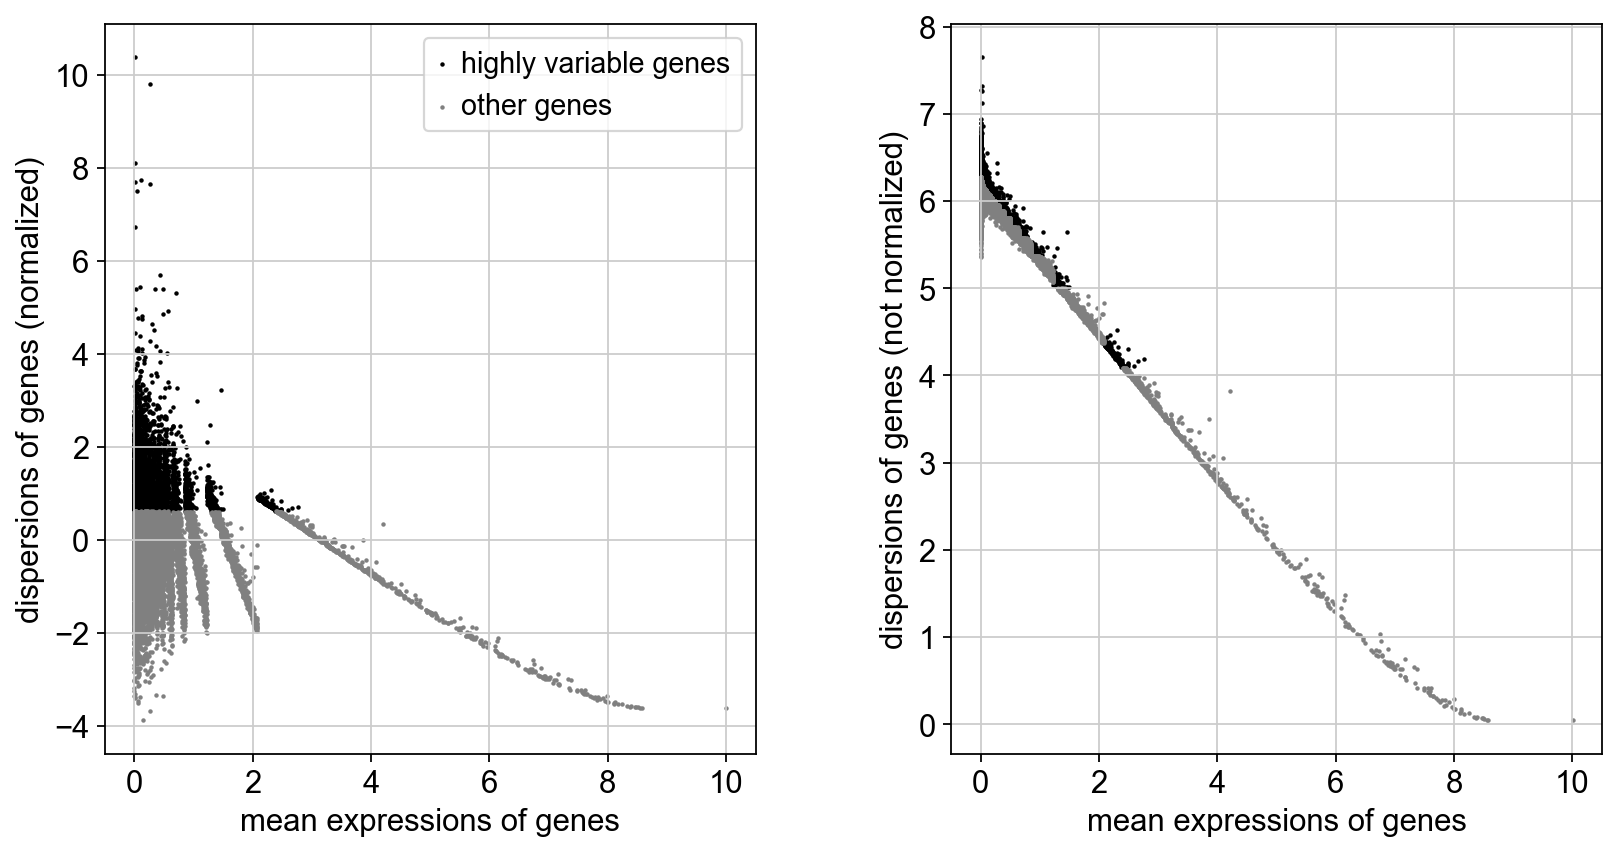

In [12]:
sc.pp.highly_variable_genes(adata, flavor='cell_ranger', n_top_genes=4000)
print('\n','Number of highly variable genes: {:d}'.format(np.sum(adata.var['highly_variable'])))

sc.pl.highly_variable_genes(adata)

In [13]:
Xgraw=np.array(adata.X.todense())
Xgraw=Xgraw[:,adata.var.highly_variable]
sc.pp.regress_out(adata, ['total_counts', 'pct_counts_mt'])


# sc.pp.regress_out(cdata, ['total_counts', 'pct_counts_mt'])
cdata=adata.copy()
sc.pp.scale(cdata,  max_value=10)
sc.pp.pca(cdata, n_comps=50, use_highly_variable=True, svd_solver='arpack')


regressing out ['total_counts', 'pct_counts_mt']
    sparse input is densified and may lead to high memory use


C:\ProgramData\Anaconda3\envs\retisepi\lib\site-packages\anndata\_core\anndata.py:1228: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'CellType' as categorical
C:\ProgramData\Anaconda3\envs\retisepi\lib\site-packages\anndata\_core\anndata.py:1228: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'oCellType' as categorical
C:\ProgramData\Anaconda3\envs\retisepi\lib\site-packages\anndata\_core\anndata.py:1228: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future versi

    finished (0:04:03)
computing PCA
    on highly variable genes
    with n_comps=50
    finished (0:00:13)


The count data has been normalized and log-transformed with an offset of 1. The latter is performed to normalize the data distributions. The offset of 1 ensures that zero counts map to zeros. We keep this data in the '.raw' part of the AnnData object as it will be used to visualize gene expression and perform statistical tests such as computing marker genes for clusters.

## 2.3 Gene Basis

Computing neighbourhood graph, using first 100 principal components. 

In [14]:

adata = adata[:, adata.var.highly_variable]

X_pca=cdata.obsm['X_pca'] 




neighbourhood matrix and its corresponding distance matrix. 

In [15]:
neigh = NearestNeighbors(n_neighbors=adata.n_obs).fit(X_pca)
knntall=neigh.kneighbors(X_pca, return_distance=True)

knndisall=knntall[0]
knndisallzs=-sp.stats.zscore(knndisall, axis=1)

knnall=knntall[1]



In [16]:
Xnrm= sp.stats.zscore(Xgraw, axis=1)
# Xnrm= sp.stats.zscore(np.array(adata.X.todense()), axis=0) 

# Xraw= np.array(adata.X.todense())
Xraw= np.array(adata.X)

we only use 5 neighbous, the first one is the cell itself. 

In [17]:
num_neigh=6
knnTrue=knnall[:,:num_neigh]


z-score normalization of nighbourhood distance, multiplying to -1, and taking median value, to be later used for cell score computation. 

In [18]:
knndisallzsc=knndisallzs.copy()
knnd_TrueTrue=knndisallzsc[:,1:num_neigh]
knnd_TrueTrue_median=np.median(knnd_TrueTrue, axis=1)

Minkowski distance for each gene's expression across cells and average expresion on neighbouring cells on "true graph" are computed to be later compared with the one obtained from predicted neighbour graph. 

In [19]:

DisTrue, knntTrue=gdis_cell_neigh(Xraw,neigh_graph= knnall[:,:num_neigh])


gene correlation for "true graph". Zero values are replaced with one to prevent divide by zero event. 

In [20]:
gene_corr_true=geneknn_corr(Xnrm, Xgraw,  knnTrue)
gene_corr_true[gene_corr_true==0]=1

The gene panel list is initialized with the first highly variable gene. Multiple executions of the code implies that initializtion does not significanly affect final list of genes (about 95% of genes were the same between different initializations). Nevertheless, 'Ube2c' was common between all initializations. 

In [21]:
gene_names=adata.var_names[adata.var.highly_variable]
geneBasis_init_0 = 'Neurod1'
geneBasis_genes= [geneBasis_init_0]


Initialization of cell neighbourhood preservation, gene correlation scores, and gene id numbers to be added to the gene panel list. We will obtain first 100 genes with the geneBasis scheme. 

In [22]:
gene_panel_len=100
cell_score=np.zeros([gene_panel_len,adata.n_obs])
gene_score=np.zeros([gene_panel_len,adata.n_vars])
gene_ids = [True if  item in geneBasis_genes else False for item in  gene_names]

Runing geneBasis scheme,

In [23]:
for iter in range(gene_panel_len):
    cdata=adata.copy()
    cdata=cdata[:,gene_ids]
#     Xin=np.array(cdata.X.todense())
    Xin=np.array(cdata.X)

    DisPredict, knnPredic=gdis_cell_neigh(Xraw, Xin,return_distance=False)


    gene_keep=np.invert(gene_ids)

        
    DisPredict[gene_ids]=DisTrue[gene_ids]
    disTP=np.abs(DisPredict-DisTrue)
    new_ind=np.argmax(disTP)

    gene_ids[new_ind]=True
    geneBasis_genes.append(gene_names[new_ind])
    # this print is to keep track of code's execution
    print('New gene is in iter : ',iter, gene_names[new_ind])

    knndPredic_zs=np.zeros([adata.n_obs,])

    for ii in range(adata.n_obs):
        knndPredic_zs[ii]=np.median(knndisallzs[ii,knnPredic[ii,1:]])
        
    cell_score[iter,:]=np.divide(knndPredic_zs, knnd_TrueTrue_median)

    gene_corr_predict=geneknn_corr(Xnrm, Xgraw,  knnPredic)
    gene_score[iter,:]=np.divide(gene_corr_predict,gene_corr_true) 



New gene is in iter :  0 Cenpf
New gene is in iter :  1 Aldh1a1
New gene is in iter :  2 Cenpa
New gene is in iter :  3 Gadd45a
New gene is in iter :  4 Lum
New gene is in iter :  5 Gja1
New gene is in iter :  6 Cd93
New gene is in iter :  7 Fabp7
New gene is in iter :  8 Aldh1a3
New gene is in iter :  9 Mgp
New gene is in iter :  10 Cdk1
New gene is in iter :  11 Dct
New gene is in iter :  12 Ccnd2
New gene is in iter :  13 Spc25
New gene is in iter :  14 Cks2
New gene is in iter :  15 Dlx2
New gene is in iter :  16 Trpm1
New gene is in iter :  17 Rrm2
New gene is in iter :  18 Neurog2
New gene is in iter :  19 Sgk1
New gene is in iter :  20 Cd34
New gene is in iter :  21 Insm2
New gene is in iter :  22 Chac1
New gene is in iter :  23 Vax2os
New gene is in iter :  24 Slc39a1
New gene is in iter :  25 Gal
New gene is in iter :  26 Igfbp7
New gene is in iter :  27 Col3a1
New gene is in iter :  28 Amt
New gene is in iter :  29 Wfdc1
New gene is in iter :  30 Penk
New gene is in iter :  3

Plotting percentage of genes and cells score below 0.25 threshold. 

Text(0, 0.5, 'Cell Score Below 0.25 Threshold')

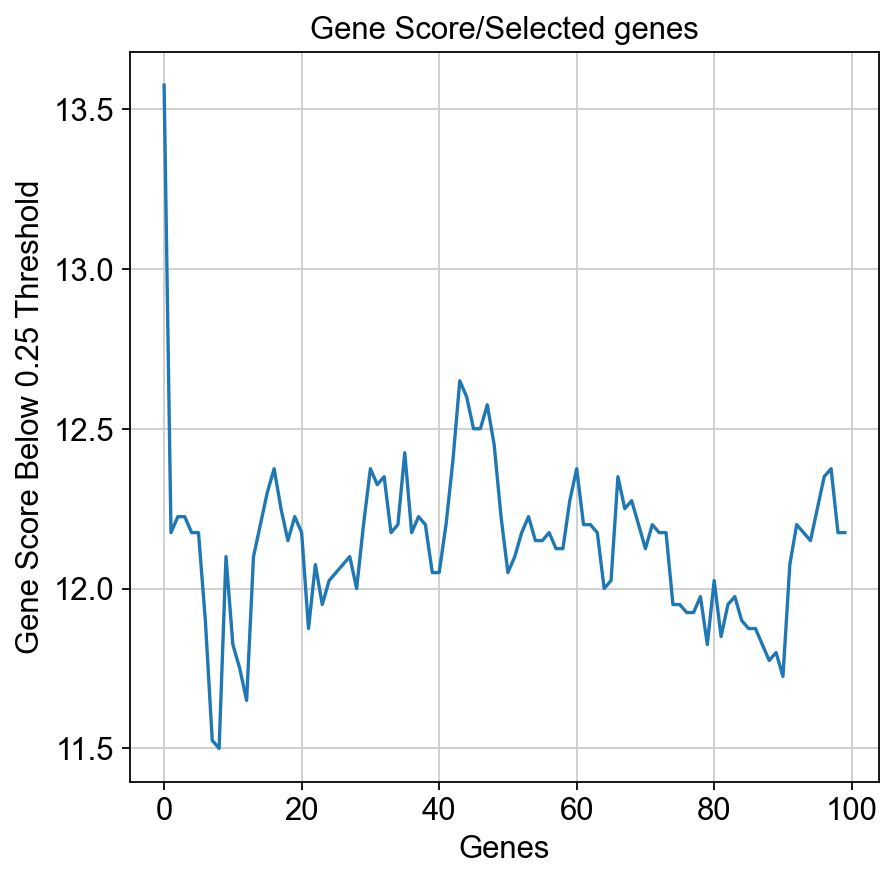

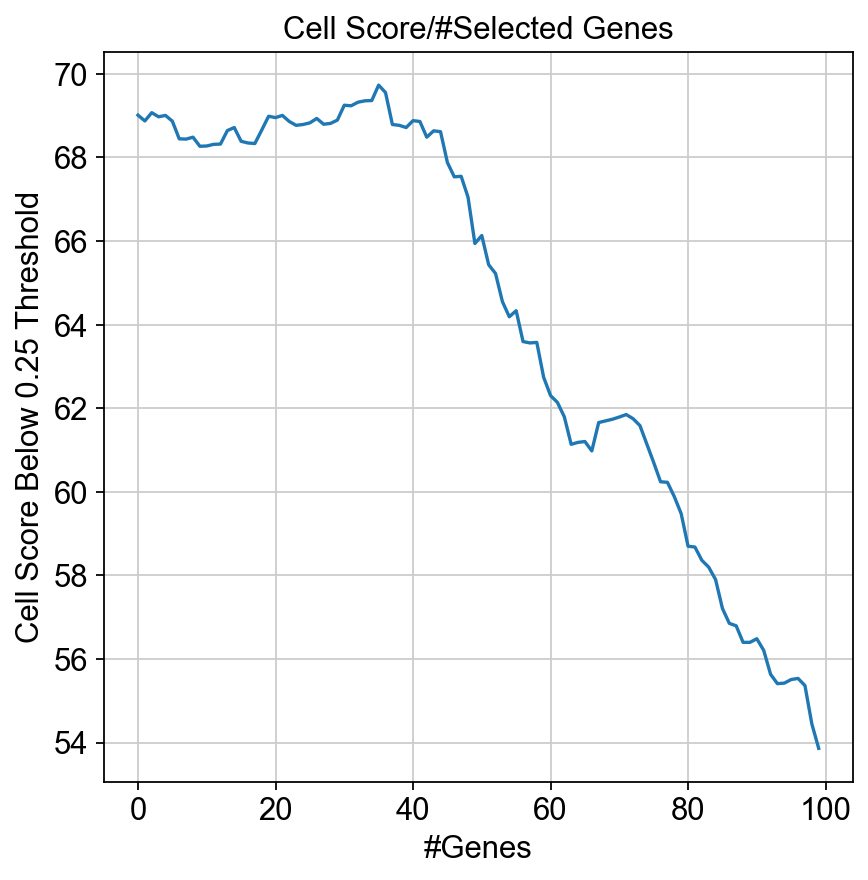

In [24]:
plt.figure()
plt.plot(np.sum(gene_score<0.25, axis=1)/adata.n_vars*100)
plt.title('Gene Score/Selected genes')
plt.xlabel('Genes')
plt.ylabel('Gene Score Below 0.25 Threshold')

plt.figure()
plt.plot(np.sum(cell_score<0.25, axis=1)/adata.n_obs*100)
plt.title('Cell Score/#Selected Genes')
plt.xlabel('#Genes')
plt.ylabel('Cell Score Below 0.25 Threshold')

Saving the results for later use. 

In [25]:
file_name='geneBasis_'+geneBasis_init_0 +'.npy'
with open(file_name, 'wb') as f:
    np.save(f, geneBasis_genes) 


# 4 Summary

In this case study, we went through the typical steps of quality control for an scRNA-seq data analysis workflow. The data obtained log normalized and used as the input for geneBasis scheme. First 100 marker genes are computed using this scheme, along with the performance measures of cell score and gene score. The quntities obtained for these scores are different with the ones geneBasis scheme developers have claimed for their dataset. I may need to implement my developed code on those datasets as well to use it as a control. Original geneBasis scheme is implemeted in R, and I'd probably need to use these code in R as well to verify my obtained results. 